In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TEST_PORTION = 0.2
PCA_PARAMETER_1 = 256
MODEL_PARAMETERS_1 = 100

In [3]:
base_dir = "../datasets/brain-tumors-256x256/Data/"

class_folder_names = os.listdir(base_dir)
class_folder_names

['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']

In [4]:
image_paths = []

for cls in class_folder_names:

    for file_name in os.listdir(base_dir+cls):
        if file_name.split(".")[-1] == 'jpg':
            image_paths.append(os.path.join(base_dir, cls, file_name))

print("A Total images = ", len(image_paths))
print("----------------------")

image_paths[0:10]

A Total images =  3096
----------------------


['../datasets/brain-tumors-256x256/Data/glioma_tumor\\G_1.jpg',
 '../datasets/brain-tumors-256x256/Data/glioma_tumor\\G_10.jpg',
 '../datasets/brain-tumors-256x256/Data/glioma_tumor\\G_100.jpg',
 '../datasets/brain-tumors-256x256/Data/glioma_tumor\\G_101.jpg',
 '../datasets/brain-tumors-256x256/Data/glioma_tumor\\G_102.jpg',
 '../datasets/brain-tumors-256x256/Data/glioma_tumor\\G_103.jpg',
 '../datasets/brain-tumors-256x256/Data/glioma_tumor\\G_104.jpg',
 '../datasets/brain-tumors-256x256/Data/glioma_tumor\\G_105.jpg',
 '../datasets/brain-tumors-256x256/Data/glioma_tumor\\G_106.jpg',
 '../datasets/brain-tumors-256x256/Data/glioma_tumor\\G_107.jpg']

In [5]:
classes = []

for image_path in image_paths:
    classes.append(image_path.split('/')[-1].split('\\')[0])

classes[0:10]

['glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor',
 'glioma_tumor']

In [6]:
dataset = []
for path in image_paths:
    image=cv2.imread(path)
    dataset.append(image)

In [7]:
x = np.array(dataset)
x.shape

(3096, 256, 256, 3)

In [8]:
labels_encoder = LabelEncoder()
y = labels_encoder.fit_transform(classes)
y = np.array(y)
y

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=TEST_PORTION)
print("Train data = ", x_train.shape, y_train.shape)
print("Test data =", x_test.shape, y_test.shape)

Train data =  (2476, 256, 256, 3) (2476,)
Test data = (620, 256, 256, 3) (620,)


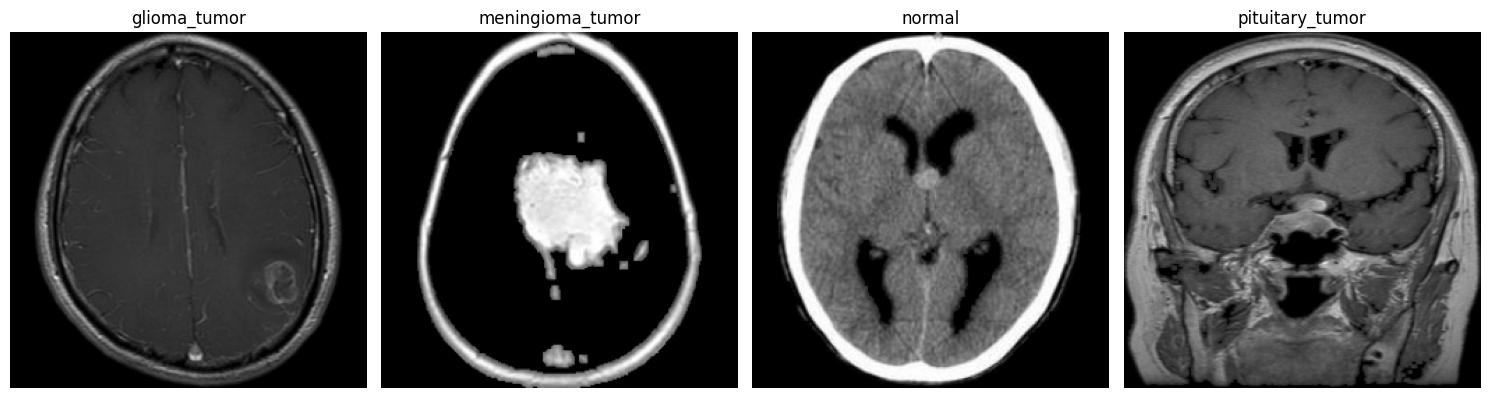

In [10]:
selected_classes = [0, 1, 2, 3]
total_images_per_class = 1

plt.figure(figsize=(15, 5))

for c, selected_class in enumerate(selected_classes):

    indices_for_selected_class = np.where(y_train == selected_class)[0]
    random_indices = np.random.choice(
        indices_for_selected_class, total_images_per_class, replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(total_images_per_class, len(selected_classes), c *
                    total_images_per_class + i + 1)
        plt.imshow(x_train[idx])
        plt.title(class_folder_names[selected_class])
        plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print("Train data shape = ", x_train.shape,  y_train.shape)
print("Test data shape = ", x_test.shape,  y_test.shape)

Train data shape =  (2476, 196608) (2476,)
Test data shape =  (620, 196608) (620,)


In [12]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)

In [13]:
pca = PCA()
X_pca = pca.fit_transform(x_scaled)

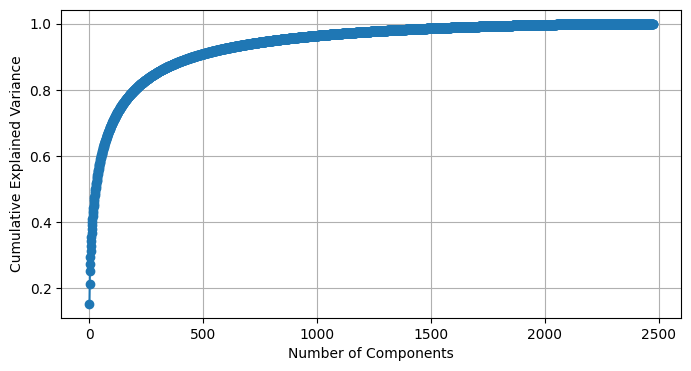

In [14]:
# Trying to figure out which number of components would be best for PCA
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [15]:
n_components = np.argmax(cumulative_variance >= 0.95) + 1
n_components

814

In [16]:
pca = PCA(n_components=n_components)

In [17]:
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
print("Train data shape= ", x_train.shape,  y_train.shape)
print("Test data shape= ", x_test.shape,  y_test.shape)

Train data shape=  (2476, 814) (2476,)
Test data shape=  (620, 814) (620,)


In [18]:
model = SVC()
model.fit(x_train, y_train);

In [19]:
y_pred = model.predict(x_test)

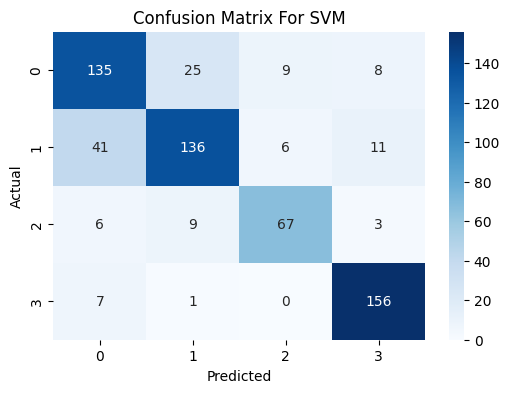

In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=True, yticklabels=True)
plt.title(
    f'Confusion Matrix For SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.76      0.74       177
           1       0.80      0.70      0.75       194
           2       0.82      0.79      0.80        85
           3       0.88      0.95      0.91       164

    accuracy                           0.80       620
   macro avg       0.80      0.80      0.80       620
weighted avg       0.80      0.80      0.80       620



In [22]:
model = RandomForestClassifier(n_estimators=MODEL_PARAMETERS_1)
model.fit(x_train, y_train);

In [23]:
y_pred = model.predict(x_test)

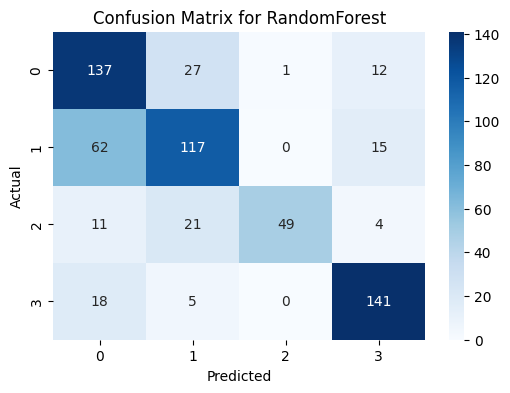

In [24]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=True, yticklabels=True)
plt.title(
    f'Confusion Matrix for RandomForest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.77      0.68       177
           1       0.69      0.60      0.64       194
           2       0.98      0.58      0.73        85
           3       0.82      0.86      0.84       164

    accuracy                           0.72       620
   macro avg       0.77      0.70      0.72       620
weighted avg       0.74      0.72      0.72       620

